# DataCamp Certification Case Study

### Project Brief

Congratulations, you have landed your first job as a data scientist at National Accessibility! National Accessibility currently installs wheelchair ramps for office buildings and schools. However, the marketing manager wants the company to start installing ramps for event venues as well. According to a new survey, approximately 40% of event venues are not wheelchair accessible. However, it is not easy to know whether a venue already has a ramp installed. 

The marketing manager would like to know whether you can develop a model to predict whether an event venue has a wheelchair ramp. To help you with this, he has provided you with a dataset of London venues. This data includes whether the venue has a ramp.

It is a waste of time to contact venues that already have a ramp installed, and it also looks bad for the company. Therefore, it is especially important to exclude locations that already have a ramp. Ideally, at least two-thirds of venues predicted to be without a ramp should not have a ramp. 

You will need to present your findings in two formats:
- First, you will need to present your findings to the marketing manager via a 10 minute oral presentation. The owner has no technical data science background. 
- You will also need to submit a technical report to your manager, who does have a strong technical data science background.

The data you will use for this analysis can be accessed here: `"data/event_venues.csv"`

In [2]:
# Import all necessary packages.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression




pd.set_option('display.max_rows', None)

In [3]:
dataset = pd.read_csv('data/event_venues.csv')

# Exploratory Data Analysis (EDA)

In [4]:
dataset.head()

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
0,techspace aldgate east,False,0,True,False,35.045455,0,112.715867,False,False
1,green rooms hotel,True,1,True,False,40.000000,120,80.000000,True,False
2,148 leadenhall street,False,0,True,False,35.045455,0,112.715867,False,False
3,conway hall,False,0,True,False,35.045455,60,60.000000,False,False
4,gridiron building,False,0,True,False,35.045455,0,112.715867,False,False


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   venue_name                  3910 non-null   object 
 1   Loud music / events         3910 non-null   bool   
 2   Venue provides alcohol      3910 non-null   int64  
 3   Wi-Fi                       3910 non-null   bool   
 4   supervenue                  3910 non-null   bool   
 5   U-Shaped_max                3910 non-null   float64
 6   max_standing                3910 non-null   int64  
 7   Theatre_max                 3910 non-null   float64
 8   Promoted / ticketed events  3910 non-null   bool   
 9   Wheelchair accessible       3910 non-null   bool   
dtypes: bool(5), float64(2), int64(2), object(1)
memory usage: 172.0+ KB


In [6]:
# See if there are any missing values.
features_with_na=[features for features in dataset.columns if dataset[features].isnull().sum()>1]

for feature in features_with_na:
    print(feature, np.round(dataset[feature].isnull().mean(), 4),  ' % missing values')

It appears that we don't have any missing values, but we will need to do more exploration to confirm.

## Venue Name


In [7]:
# Lets check if there are any venues that are double counted (via name)

n_unique_names = dataset['venue_name'].nunique()
total_venues = len(np.array(dataset['venue_name']))
print('There are', n_unique_names, 'unique venues out of', total_venues, 'total venues.')

There are 1444 unique venues out of 3910 total venues.


This could be an issue. We might have duplicate rows, but we could also have different rooms/venues at the same address. More exploration is needed.

In [8]:
# Checking for fully duplicated rows

duplicate = dataset.duplicated()
print('There are', duplicate.sum(), 'duplicate rows.')

There are 450 duplicate rows.


Even though there appears to be 450 duplicate rows, it it possible that the number of duplicates is actually smaller. It is possible that we have more than one duplicate per row. This is would be the best case scenario.

In [9]:
duplicated_df = dataset[duplicate]
n_unique_names = duplicated_df['venue_name'].nunique()
total_venues = len(np.array(duplicated_df['venue_name']))
print('There are', n_unique_names, 'unique venues out of', total_venues, 'total duplicate venues.')

There are 227 unique venues out of 450 total duplicate venues.


We have found that there are actually only 227 rows that had duplicates, so even though we will most likely delete 450 rows, we are not losing 450 data points, but rather just 227. Note, that these duplicates are not accounting for venues with the same name, but different feature values.

In [10]:
dataset.loc[dataset['venue_name'] == 'lloyds avenue']

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
6,lloyds avenue,False,0,True,False,35.045455,0,112.715867,False,False
65,lloyds avenue,False,0,True,False,35.045455,0,112.715867,False,False
85,lloyds avenue,False,0,True,False,35.045455,0,112.715867,False,False
225,lloyds avenue,False,0,True,False,35.045455,0,112.715867,False,False
1405,lloyds avenue,False,0,True,False,14.000000,0,30.000000,False,False
1569,lloyds avenue,False,0,True,False,35.045455,0,112.715867,False,False


As an example, lets look at the venue "Lloyds Avenue". We can see that rows 6, 65, 85, 225, and 1569 all have the same values, so for all intents and purposes, we can treat them as the same venue and keep only one of the rows. However, row 1405 has different occupancy numbers for the features "U-Shaped max" and "Theatre_max", so we will treat it as a seperate venue and keep it. As a result, we will only be keeping rows 6 and 1405

In [11]:
# Here we drop all of the duplicate rows.
dataset = dataset.drop_duplicates()
dataset.loc[dataset['venue_name'] == 'lloyds avenue']

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
6,lloyds avenue,False,0,True,False,35.045455,0,112.715867,False,False
1405,lloyds avenue,False,0,True,False,14.000000,0,30.000000,False,False


As we can see, after we drop the duplicates we have only rows 6 and 1405 left. 

## Continuous Features

In [12]:
dataset.describe()

,Venue provides alcohol,U-Shaped_max,max_standing,Theatre_max
count,3460.000000,3460.000000,3460.000000,3460.000000
mean,0.743353,35.093431,126.390462,113.287819
std,0.436846,46.643692,285.898114,138.630541
min,0.000000,1.000000,0.000000,1.000000
25%,0.000000,35.045455,20.000000,70.000000
50%,1.000000,35.045455,60.000000,112.715867
75%,1.000000,35.045455,150.000000,112.715867
max,1.000000,2520.000000,7500.000000,4000.000000


From the description of the features provided in the case study description, it sounds like U-Shaped_max + max_standing = Theatre_max. However, max_standing has a higher mean than Theatre_max. Lets takea look

In [13]:
dataset.loc[dataset['U-Shaped_max'] + dataset['max_standing'] == dataset['Theatre_max']]

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
186,"doubletree by hilton hotel, ealing",False,1,True,False,30.0,50,80.0,False,False
306,"landmark – euston, london",False,0,False,False,20.0,0,20.0,False,False
1154,gridiron building,False,0,True,False,20.0,0,20.0,False,False
3500,radisson blu edwardian npw,True,1,True,False,50.0,200,250.0,False,True
3906,"landmark - aldgate, london",False,0,True,False,28.0,0,28.0,False,True


It appears that there are only 5 rows where this assumption holds true. Therefore, we cannot treat Theatre_max as the sum of the other two numerical features.

In [14]:
data = dataset.copy()
data['diff_occupancy'] = np.abs(data['U-Shaped_max'] + data['max_standing'] - data['Theatre_max'])
print('Average difference: {}'.format(np.round(data['diff_occupancy'].mean(), 2)))

Average difference: 97.01


Looking even further, Theatre_max and the sum of U-Shaped_max and max_standing are, on average, off by almost 100 people.

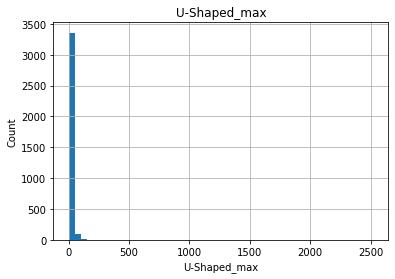

In [ ]:
# Visuallize the distributions of the continous variables
continuous_features = ['U-Shaped_max', 'max_standing', 'Theatre_max']

for feature in continuous_features:
    data=dataset.copy()
    data[feature].hist(bins=50)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

It appears that most of our venues have zero (or very low) max occupancy.

In [ ]:
# Lets look at the percentage of occupancy under 500 poeple

for feature in continuous_features:
    percent = (dataset[feature] <= 500).sum() / len(dataset[feature])
    print(feature,':', np.round(percent, 4)*100,  ' % data points')

As we can see, over 95% of all of our occupancy areas have a max occupany of under 500 people. Let's limit our histograms to get a better visualization.

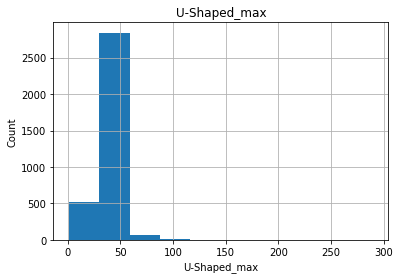

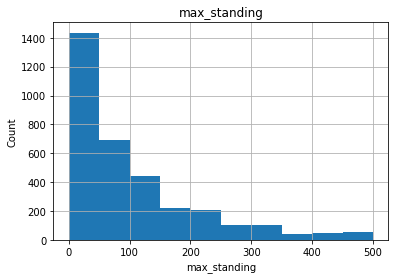

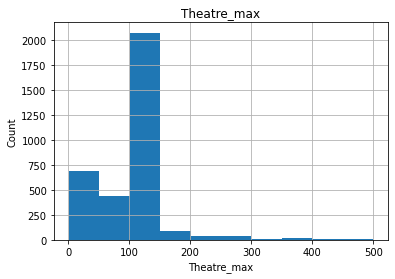

In [598]:
for feature in continuous_features:
    data=dataset.copy()
    data.loc[data[feature] <= 500][feature].hist(bins=10)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

The histogram confirms our assumption that over 95% of the venues will be low occupancy (500 or less). Furthermore, we can see that the majority of venues will have a max theares occupancy of under 300. Additionally, we can see that our features are not Guassian distributed and may have skew. We will need to address this in the feature engineering stage.

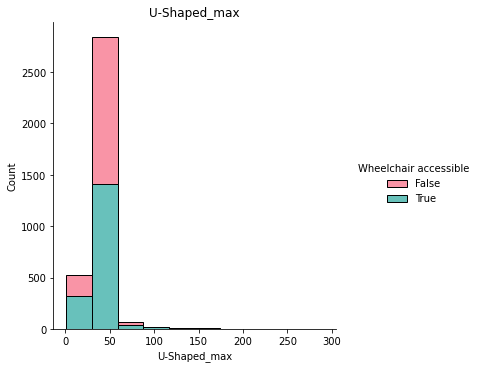

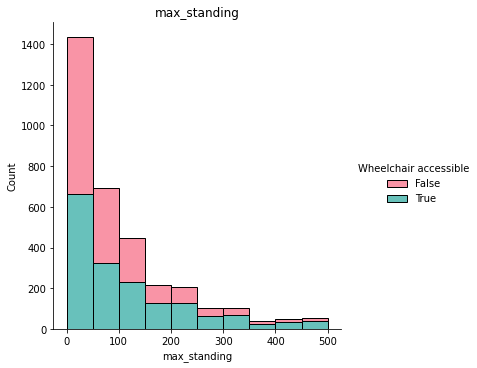

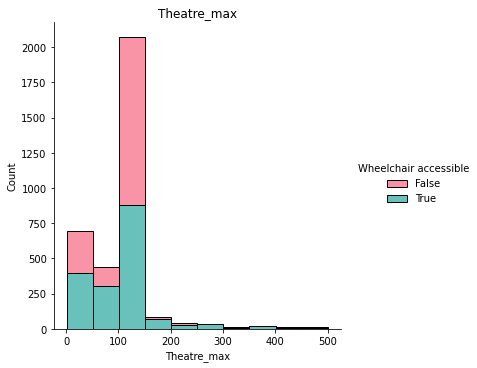

In [599]:
for feature in continuous_features:
    data=dataset.copy()
    sns.displot(data=data.loc[data[feature] <= 500], x=feature, hue="Wheelchair accessible", multiple="stack", kind='hist', bins=10, palette = 'husl')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

Looking at these histograms, it appears that for all three of our numeric features, the likelyhood that a venue has wheelchair access increases with maximum occuapancy.

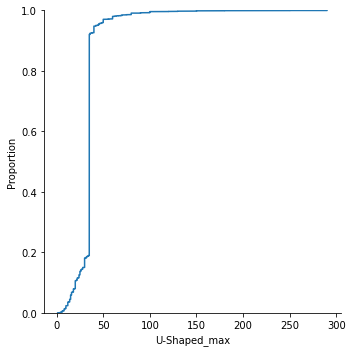

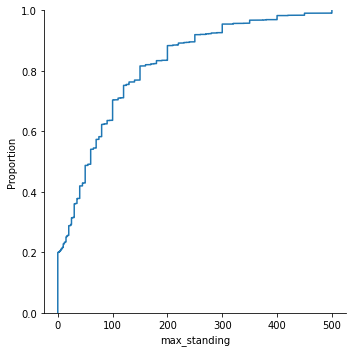

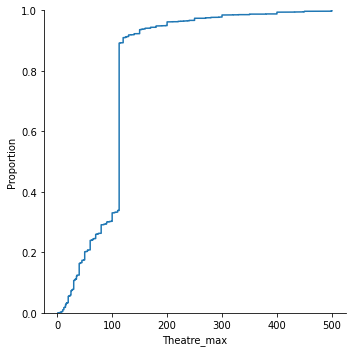

In [600]:
# Let's plot the ECDF's to further look at our distrubutions of continious features, continuing with just looking at venues with under 500 poeple occupany in each area.
for feature in continuous_features:
    data=dataset.copy()
    data = data.loc[data[feature] <= 500]
    sns.displot(data, x=feature, kind="ecdf")


As we can see, all of our continuous categories have majority small values. We know from the five-number summary, that only max_standing has zero values. This makes sense since some venues will not have standing areas. This also further proves our assumption that the majority of our venues have a max occupancy of under 200. From this graph, we further confirm our previous assertion that these features are not Guassian distributed.

In [601]:
# Look into the percentage of zero values
for feature in continuous_features:
    percent = (dataset[feature] == 0).sum() / len(dataset[feature])
    print(feature,':', np.round(percent, 4),  ' % zero values')

U-Shaped_max : 0.0  % zero values
max_standing : 0.1931  % zero values
Theatre_max : 0.0  % zero values


Almost 20% of the venues do not have a standing area, but all of the venues have a non-zero U-Shaped occupancy. This falls into line with our previous assumption that some venues will not have a standing area.

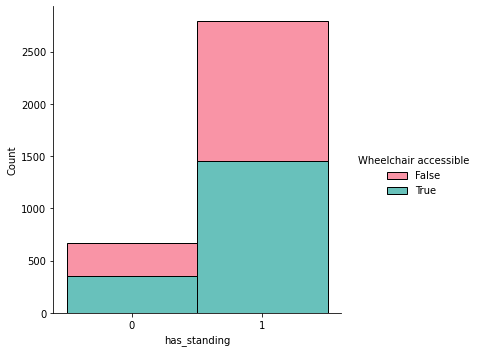

In [602]:
# Let's look at the relationship between having a standing area and having a ramp.
df = dataset.copy()
df['has_standing'] = np.where(df['max_standing'] == 0, '0', '1')
sns.displot(df, x="has_standing", hue="Wheelchair accessible", multiple="stack", palette='husl')

It does not appear that having a standing area has any impact on whether the venue has wheelchair access. It looks to be approximately a 50% split regardless if there is a standing area.

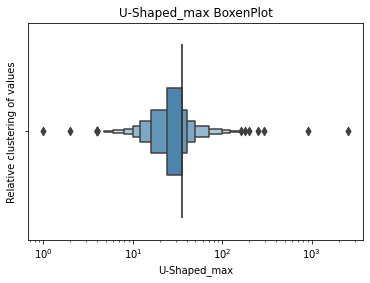

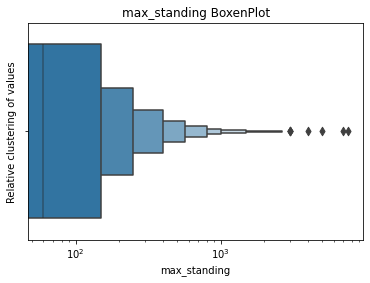

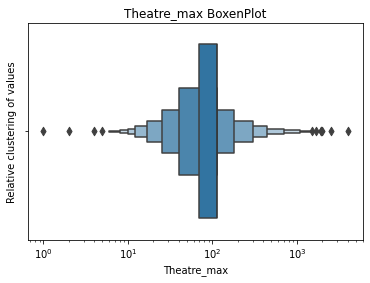

In [603]:
# Finally, lets look that the box plots to identify outliers.

for feature in continuous_features:
    data = dataset.copy()
    ax = sns.boxenplot(x=feature, orient='h', data=data)
    plt.xscale('log')
    plt.title(feature + ' BoxenPlot')
    plt.ylabel('Relative clustering of values')
    plt.show()

From these plots, we see we have very few outliers. Let's look at the outliers and see if we can discern even more.

In [604]:
# Let's look at how many of the oulier values have wheelchair accessibility.
for feature in continuous_features:
    data=dataset.copy()
    percent = np.round(data.loc[data[feature] > 500]['Wheelchair accessible'].sum() / len(data.loc[data[feature] > 500]['Wheelchair accessible']) * 100, 2)
    total = len(data.loc[data[feature] > 500]['Wheelchair accessible'])
    print('{}% of venues with {} over 500 have wheelchair accessibility with a total of {} rows.'.format(percent, feature, total))
    
total_num = dataset.loc[(data['U-Shaped_max'] > 500) | (data['max_standing'] > 500) | (data['Theatre_max'] > 500)]
total_num_without_dups = total_num[~total_num.duplicated()]
print('Total number of outlier rows accounting for overlap in features: {}'.format(total_num_without_dups.shape[0]))
print('Percentage of dataset that are outliers: {}%'.format(np.round(total_num_without_dups.shape[0]/dataset.shape[0]*100, 2)))

100.0% of venues with U-Shaped_max over 500 have wheelchair accessibility with a total of 2 rows.
83.19% of venues with max_standing over 500 have wheelchair accessibility with a total of 119 rows.
97.3% of venues with Theatre_max over 500 have wheelchair accessibility with a total of 37 rows.
Total number of outlier rows accounting for overlap in features: 133
Percentage of dataset that are outliers: 3.84%


As we can see from the percentages above, most of the venues that have over 500 max occupancy in any of the three features have wheelchair accessibility. Since our measure of success is to predict when a venue does not have wheelchair accessibility AND these values are outliers to our dataset, we can drop these rows. Additionally, there are only 133 of these rows, which account for under 4% of our dataset.

## Categorical Variables

In [605]:
categorical_features = ['Loud music / events', 'Venue provides alcohol', 'Wi-Fi', 'supervenue', 'Promoted / ticketed events']

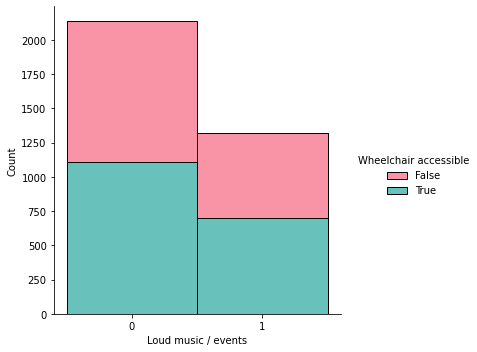

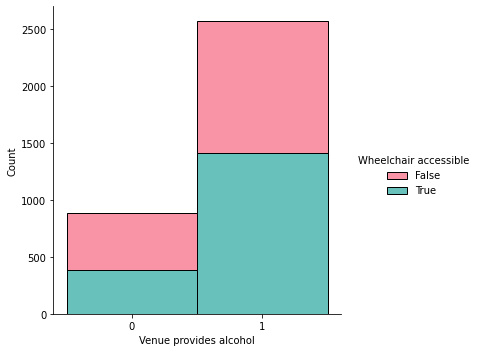

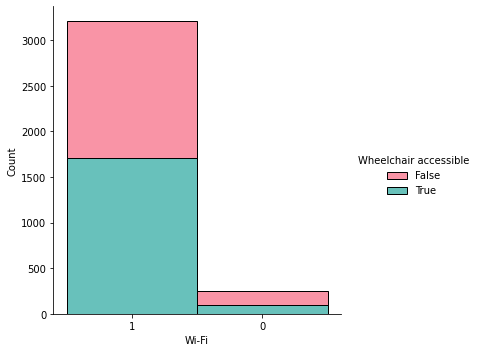

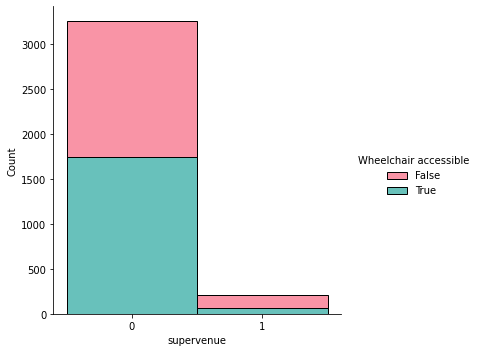

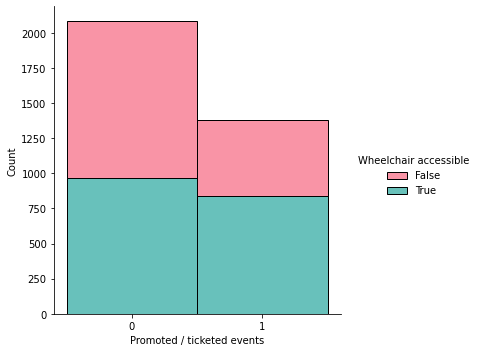

In [606]:
for feature in categorical_features:
    data = dataset.copy()
    data[feature] = np.where(data[feature] == 0, '0', '1')
    sns.displot(data, x=feature, hue="Wheelchair accessible", multiple="stack", kind='hist', palette="husl")

There seems to be a pretty even split for every feature, but there are a few features that stand out:
- Super Venues are much less likely to have wheelchair access.
- Venues without wifi are less likely to have wheelchair access.
- Venues that do not provide alchohol are less likely to have wheelchair access.
- Whether venues that have ticketed events or have loud music events do not seem to have impact on wheelchair access. 

In [607]:
# Let's look at the correlation matrix for the categorical features

all_features = [feature for feature in dataset.columns if feature not in ['venue_name', 'Wheelchair accessible']]


dataset[all_features].corr()

,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events
Loud music / events,1.000000,0.241746,0.011990,-0.008839,0.040048,0.130542,0.077631,0.333494
Venue provides alcohol,0.241746,1.000000,0.007924,-0.113068,-0.019552,0.130655,0.046074,0.043804
Wi-Fi,0.011990,0.007924,1.000000,0.032787,-0.002948,-0.083331,-0.062414,0.011644
supervenue,-0.008839,-0.113068,0.032787,1.000000,-0.014995,-0.071812,-0.036221,0.008001
U-Shaped_max,0.040048,-0.019552,-0.002948,-0.014995,1.000000,0.064794,0.092681,0.042827
max_standing,0.130542,0.130655,-0.083331,-0.071812,0.064794,1.000000,0.447548,0.115662
Theatre_max,0.077631,0.046074,-0.062414,-0.036221,0.092681,0.447548,1.000000,0.097219
Promoted / ticketed events,0.333494,0.043804,0.011644,0.008001,0.042827,0.115662,0.097219,1.000000


Examining the correlation matrix, there are no correlation values greater than 0.35 in magnitude. Therefore, none of the features heavily affect one another and can all be used together in a final model. To confirm this visually, let's plot.

<AxesSubplot:title={'center':'Heatmap of correlation matrix'}>

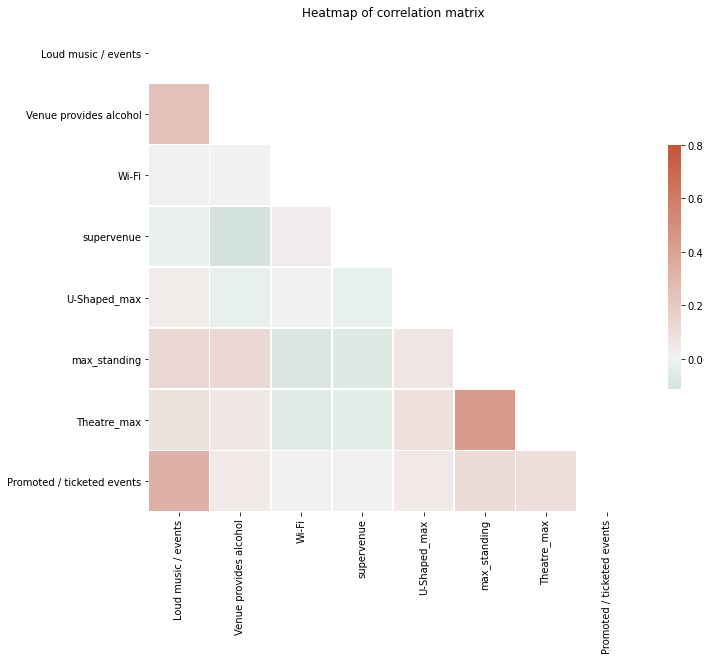

In [608]:
# Compute the correlation matrix
corr = dataset[all_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
plt.title('Heatmap of correlation matrix')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As we can see, most of the values are very low, with our correlation_maxtrix having a maximum of under 0.35 correlation.

# Feature Engineering

### Dealing with name column

In [609]:
# Venue name is not a helpful feature. It is simply an identifier, so we will drop it
venue_name = dataset['venue_name']
dataset = dataset.drop('venue_name', axis=1)

### Converting bool categories to one hot encodings

In [610]:
# Since all of our categorical features are booleans, we can do a simple binary one hot encoding instead of using pandas.get_dummies()

#Note, wheelchair accessible is part of bool_categories since we need it to be binary for our model.
bool_categories = ['Loud music / events', 'Wi-Fi', 'supervenue', 'Promoted / ticketed events', 'Wheelchair accessible']

for feature in bool_categories:
    dataset[feature] = np.where(df[feature] == True, 1, 0)

In [611]:
dataset.head()

,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
0,0,0,1,0,35.045455,0,112.715867,0,0
1,1,1,1,0,40.000000,120,80.000000,1,0
2,0,0,1,0,35.045455,0,112.715867,0,0
3,0,0,1,0,35.045455,60,60.000000,0,0
4,0,0,1,0,35.045455,0,112.715867,0,0


### Numeric Features

In [612]:
# Removing outliers
ouliers = dataset.loc[(data['U-Shaped_max'] > 500) | (data['max_standing'] > 500) | (data['Theatre_max'] > 500)]
outliers_without_dups = total_num.drop_duplicates()
dataset = dataset.drop(outliers_without_dups.index)

In [613]:
# Normalizing features that have only nonzero values
for feature in continuous_features:
    if 0 in data[feature].unique():
        pass
    else:
        dataset[feature] = np.log(dataset[feature])

We have successfully logararithmically normalized the "U-Shaped_max" and the "Theatre_max" column.

In [614]:
# Make sure all columns are on the same scale
feature_scale=[feature for feature in dataset.columns if feature not in ['Wheelchair accessible']]

scaler=MinMaxScaler()

data = pd.concat([pd.DataFrame(scaler.fit_transform(dataset[feature_scale]), columns=feature_scale),
                 dataset[['Wheelchair accessible']].reset_index(drop=True)],
                    axis=1)

data.head(10)

,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
0,0.0,0.0,1.0,0.0,0.671278,0.00,0.760284,0.0,0
1,1.0,1.0,1.0,0.0,0.696236,0.24,0.705117,1.0,0
2,0.0,0.0,1.0,0.0,0.671278,0.00,0.760284,0.0,0
3,0.0,0.0,1.0,0.0,0.671278,0.12,0.658826,0.0,0
4,0.0,0.0,1.0,0.0,0.671278,0.00,0.760284,0.0,0
5,1.0,1.0,1.0,0.0,0.338175,0.00,0.760284,1.0,0
6,0.0,0.0,1.0,0.0,0.671278,0.00,0.760284,0.0,0
7,1.0,1.0,1.0,0.0,0.671278,0.40,0.760284,0.0,0
8,0.0,0.0,1.0,0.0,0.671278,0.00,0.760284,0.0,0
9,1.0,1.0,1.0,0.0,0.671278,0.36,0.482047,1.0,0


# Modeling

In [615]:
from sklearn.metrics import make_scorer
def model_accuracy_no_ramp(y_true, y_pred):
    total = 0
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == 0:
            total += 1
            if y_pred[i] == 0:
                correct += 1
    return correct / total

While we will be also be using simple accuracy as a metric to determine how well our model is performing, we will also be using the accuracy of no ramp (defined above) as it is our measure of success.

In [616]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(data.drop('Wheelchair accessible', axis=1), data['Wheelchair accessible'],test_size=0.2,random_state=34, stratify=data['Wheelchair accessible'])

In [617]:
# Since we have a binary target, we will use logistic regresstion for our model
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,y_train)

print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.6136699628997447


In [626]:
logreg_model = LogisticRegression(C=10, penalty='l2')
logreg_model.fit(X_train,y_train)
y_pred_logreg = logreg_model.predict(X_test)

logreg_score = logreg_model.score(X_test, y_test)
logreg_no_ramp_score = model_accuracy_no_ramp(np.array(y_test), y_pred_logreg)
print("The logistic regression model has an accuracy score of {} and a no-ramp accuracy score of {}.".format(np.round(logreg_score, 4), np.round(logreg_no_ramp_score, 4)))

The logistic regression model has an accuracy score of 0.5706 and a no-ramp accuracy score of 0.5427.


This accuracy is not great, so let's try other models to see if we can improve.

In [619]:
from sklearn.ensemble import RandomForestClassifier
grid={"n_estimators":[25, 50, 100, 150, 200], 'min_samples_split':[5, 10, 15], 'max_features':['auto', 'sqrt', 'log2']}
rf=RandomForestClassifier()
rf_cv=GridSearchCV(rf,grid,cv=5)
rf_cv.fit(X_train,y_train)

print("tuned hyperparameters :(best parameters) ", rf_cv.best_params_)
print("accuracy :", rf_cv.best_score_)

tuned hyperparameters :(best parameters)  {'max_features': 'auto', 'min_samples_split': 15, 'n_estimators': 200}
accuracy : 0.6433593364273724


In [627]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=15, max_features='auto') 
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)

rf_score = rf_model.score(X_test, y_test)
rf_no_ramp_score = model_accuracy_no_ramp(np.array(y_test), y_pred_rf)
print("The random forest model has an accuracy score of {} and a no-ramp accuracy score of {}.".format(np.round(rf_score, 4), np.round(rf_no_ramp_score, 4)))

The random forest model has an accuracy score of 0.6111 and a no-ramp accuracy score of 0.5945.


Our accuracy is improving, but lets try to do better.

In [621]:
from sklearn.ensemble import GradientBoostingClassifier
grid={"n_estimators":[50, 100, 150, 200], 'loss':['deviance', 'exponential'], 'learning_rate':np.linspace(0.1, 1, 5)}
gb=GradientBoostingClassifier()
gb_cv=GridSearchCV(gb,grid,cv=5)
gb_cv.fit(X_train,y_train)

print("tuned hyperparameters :(best parameters) ", gb_cv.best_params_)
print("accuracy :", gb_cv.best_score_)

tuned hyperparameters :(best parameters)  {'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 150}
accuracy : 0.6512533679414296


In [622]:
gb_model = GradientBoostingClassifier(n_estimators=150, loss='deviance', learning_rate=0.1) 
gb_model.fit(X_train,y_train)
y_pred_gb = gb_model.predict(X_test)

gb_score = gb_model.score(X_test, y_test)
gb_no_ramp_score = model_accuracy_no_ramp(np.array(y_test), y_pred_gb)
print("The gradient boosting model has an accuracy score of {} and a no-ramp accuracy score of {}.".format(np.round(gb_score, 4), np.round(gb_no_ramp_score, 4)))

The gradient boosting model has an accuracy score of 0.6171 and a no-ramp accuracy score of 0.6433.


This is the best improvement we have seen so far!

In [623]:
from sklearn.ensemble import AdaBoostClassifier

grid={"n_estimators":[50, 100, 150, 200], 'learning_rate':np.linspace(0.1, 1, 5)}
ada=GradientBoostingClassifier()
ada_cv=GridSearchCV(ada,grid,cv=5)
ada_cv.fit(X_train,y_train)

print("tuned hyperparameters :(best parameters) ", ada_cv.best_params_)
print("accuracy :", ada_cv.best_score_)

tuned hyperparameters :(best parameters)  {'learning_rate': 0.325, 'n_estimators': 50}
accuracy : 0.6512568945816699


In [624]:
ada_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.55) 
ada_model.fit(X_train,y_train)
y_pred_ada = ada_model.predict(X_test)

ada_score = ada_model.score(X_test, y_test)
ada_no_ramp_score = model_accuracy_no_ramp(np.array(y_test), y_pred_ada)
print("The ada boosting model has an accuracy score of {} and a no-ramp accuracy score of {}.".format(np.round(ada_score, 4), np.round(ada_no_ramp_score, 4)))

The ada boosting model has an accuracy score of 0.5961 and a no-ramp accuracy score of 0.6463.


This is very similar to the previous model. In an attempt to gain a higher accuracy, we will ensemble our two best performing models.

In [625]:
ensemble_proba = gb_model.predict_proba(X_test) + ada_model.predict_proba(X_test)
y_pred_ensemble = np.where(ensemble_proba[:,0] > ensemble_proba[:,1], 0, 1)

ensemble_no_ramp_score = model_accuracy_no_ramp(np.array(y_test), y_pred_ensemble)
print("The ensemble model has a no-ramp accuracy score of {}.".format(np.round(ensemble_no_ramp_score, 4)))

The ensemble model has a no-ramp accuracy score of 0.6616.


This is an increase in model performance. In fact, we have almost we have almost achieved the ideal model requested in the case study description.

# Results

### Data Exploration
In our exploration of the data, we found that we had over 200 duplicate rows of information. After removal, we looked at our numeric features where we found outlier values in the form of venues with a high maximum occupancy. Looking closer at these values, we saw that most of these venues already had wheelchair access. This makes sense, since the larger venues in London will most likely have wheelchair access. Since we are trying to correctly predict when a venue does not have a ramp, I decided that we could remove the outliers from further analysis. This raised the question if this trend continued to present itself even in the lower occupancy venues. Looking at the graph, we see that this is definitely the case. The higher the maximum occupancy, the more likely the venue has wheelcahir access.

Looking at the catergorical values, we applied a similar analysis and we found:
- Super Venues are less likely to have wheelchair access.
- Venues without wifi are less likely to have wheelchair access.
- Venues that do not provide alchohol are less likely to have wheelchair access.
- Whether venues that have ticketed events or have loud music events do not seem to have impact on wheelchair access.

However, none of the trends in the categorical values were as showed more correlation than the numerical features. This leads me to believe that our most import features are: Theatre_max, max_standing, U-Shaped_max, Wifi, supervenue, and venue provides alcohol (in that order).

### Modeling

When modeling, I find that it is a good practice to start simple and slowly increase model complexity. I trained four classification models starting with the simplest, Logistic Regression, and getting more complex up to an AdaBoost model. The models no-ramp accuracy (accuracy of correctly predicting no ramp) kept increasing with the no-ramp accuracies of: 54.27%, 59.45%, 64.33%, 64.63%. In an attempt to increase the no-ramp accuracy, I combined the final two models and achieved an accuracy of 66.16%. Since this is greater than any of the single models, this combined, or ensemble, model is the best model. Additionally, this model nearly matches the ideal model in the case study, predicting no ramp venues correctly almost two-thirds of the time.

### Future Work

In the future there are a few things we could try to improve the accuracy of the model. 
1. I'd like to try to build a model using only some of the features to see how they affect model performance. Perhaps a rolling training where we keep adding one feature at a time.
2. I'd like to reintroduce the outliers to see if they improve my accuracy
3. I'd like to try more models, such as SVMs and Gaussian Naive Bayes

These three areas would be the best place to start when attempting to improve this model.